In [ ]:
# Web Application Attack Detection using SVM

## Author: Shalev Mazuz
## Description: This notebook implements a SVM classifier to detect web application attacks.

In [1]:
# Essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import sklearn.svm as svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

# Other
import warnings
warnings.filterwarnings('ignore')
from collections import Counter


In [2]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Shalev Mazuz- Final report/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX-CSV.csv")

# Quick overview
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170366 entries, 0 to 170365
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             170366 non-null  int64  
 1    Flow Duration                170366 non-null  int64  
 2    Total Fwd Packets            170366 non-null  int64  
 3    Total Backward Packets       170366 non-null  int64  
 4   Total Length of Fwd Packets   170366 non-null  int64  
 5    Total Length of Bwd Packets  170366 non-null  int64  
 6    Fwd Packet Length Max        170366 non-null  int64  
 7    Fwd Packet Length Min        170366 non-null  int64  
 8    Fwd Packet Length Mean       170366 non-null  float64
 9    Fwd Packet Length Std        170366 non-null  float64
 10  Bwd Packet Length Max         170366 non-null  int64  
 11   Bwd Packet Length Min        170366 non-null  int64  
 12   Bwd Packet Length Mean       170366 non-nul

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,170366.000000,1.703660e+05,170366.000000,170366.000000,1.703660e+05,1.703660e+05,170366.000000,170366.000000,170366.000000,170366.000000,...,170366.000000,170366.000000,1.703660e+05,1.703660e+05,1.703660e+05,1.703660e+05,1.703660e+05,1.703660e+05,1.703660e+05,1.703660e+05
mean,7897.090599,1.246354e+07,15.124620,18.022276,5.569859e+02,3.183147e+04,167.775982,22.697786,48.233250,47.235628,...,11.925108,25.584506,7.433804e+04,4.676038e+04,1.646422e+05,5.012699e+04,3.690478e+06,1.310724e+05,3.784764e+06,3.543232e+06
std,18235.489428,3.193852e+07,1123.107756,1494.492871,7.710431e+03,3.460816e+06,461.299214,37.990783,94.947821,141.927429,...,1077.898793,6.354041,6.182048e+05,3.689605e+05,9.958673e+05,5.606797e+05,1.298830e+07,1.733767e+06,1.325135e+07,1.284183e+07
min,0.000000,-1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,53.000000,1.920000e+02,1.000000,1.000000,3.100000e+01,6.000000e+00,23.000000,0.000000,7.882314,0.000000,...,0.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.000000,3.141200e+04,2.000000,2.000000,6.800000e+01,1.340000e+02,41.000000,6.000000,38.000000,0.000000,...,1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,443.000000,8.169818e+05,4.000000,2.000000,1.480000e+02,3.280000e+02,60.000000,41.000000,50.000000,17.897858,...,3.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65529.000000,1.200000e+08,200755.000000,270686.000000,1.197199e+06,6.270000e+08,23360.000000,1729.000000,4183.057143,5463.493850,...,192491.000000,60.000000,1.030000e+08,6.370000e+07,1.030000e+08,1.030000e+08,1.200000e+08,7.260000e+07,1.200000e+08,1.200000e+08


In [ ]:
# Alter to binary class
df.columns = df.columns.str.strip()
df['Label'] = df['Label'].apply(lambda x: 'BENIGN' if x.strip().upper() == 'BENIGN' else 'ATTACK')

# Remove problemtaic rows
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

# Separate features and target
X = df.drop("Label", axis=1)
y = df["Label"]

# Encode categorical features
le = LabelEncoder()
y = le.fit_transform(df['Label'])

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]
X = pd.DataFrame(X_selected, columns=selected_features)

# Check for class imbalance
print("Class distribution:", Counter(y))

Class distribution: Counter({np.int64(1): 168051, np.int64(0): 2180})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
svm_classifier = svm.SVC(C = 100, gamma = 1)
svm_classifier.fit(X_train, y_train)

SVC(C=100, gamma=1)

Accuracy: 0.9986489264839781

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       436
           1       1.00      1.00      1.00     33611

    accuracy                           1.00     34047
   macro avg       0.96      0.99      0.97     34047
weighted avg       1.00      1.00      1.00     34047


Confusion Matrix:


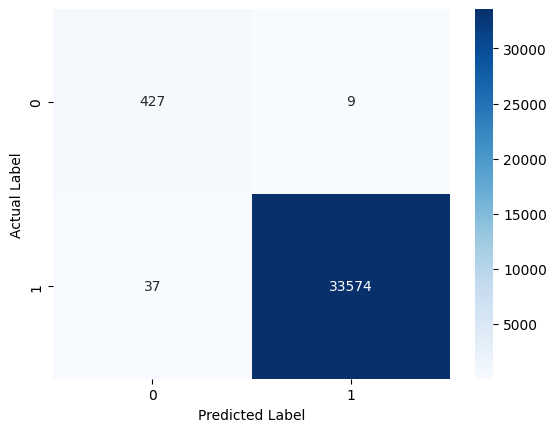

In [ ]:
# Model evaluation
y_pred = svm_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

**All of the following code is for analysis purposes**

  0%|          | 0/100 [00:00<?, ?it/s]

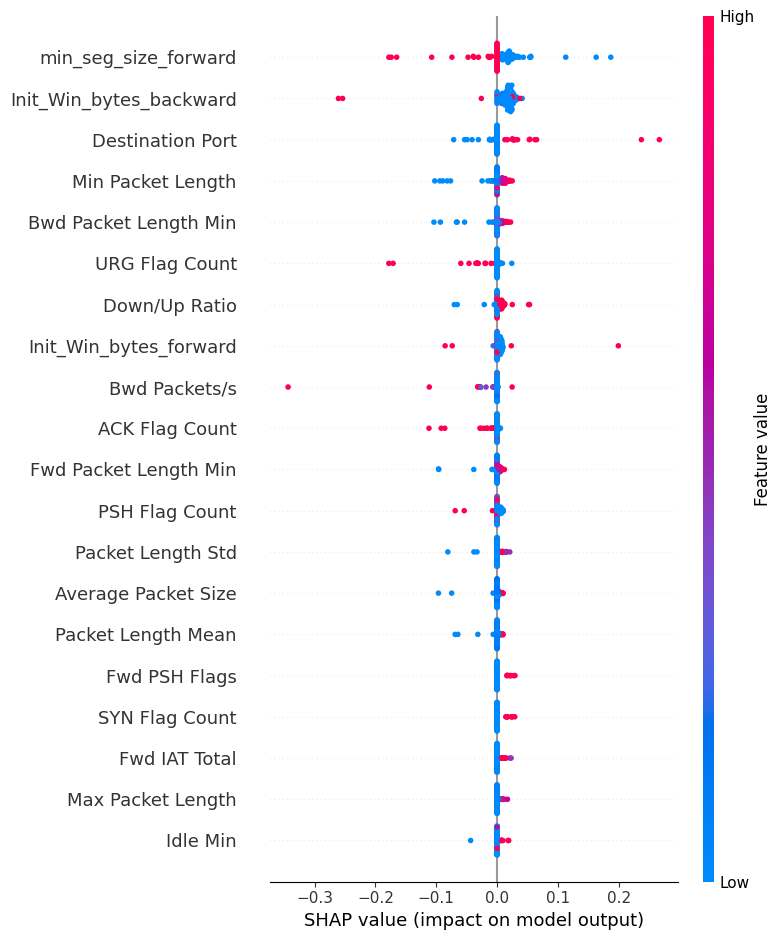

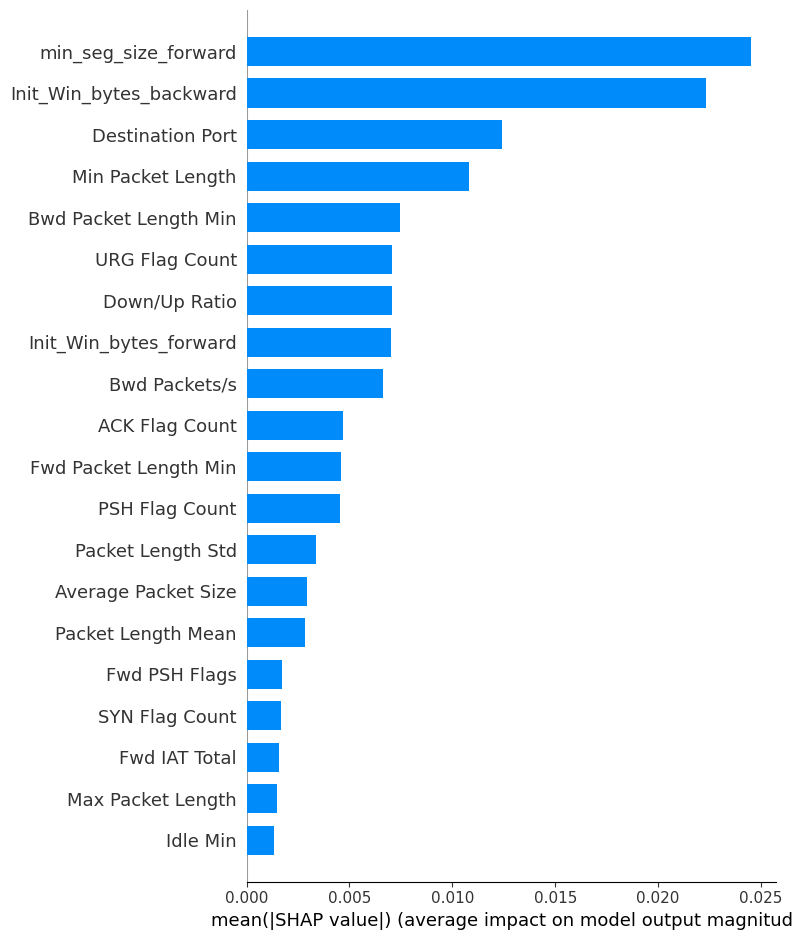

In [ ]:
import shap
import numpy as np

explainer = shap.KernelExplainer(svm_classifier.predict, shap.sample(X_train, 100, random_state=42))

# Compute SHAP values for a sample of test data
shap_values = explainer.shap_values(shap.sample(X_test, 100, random_state=42))

# Summary plot (beeswarm)
shap.summary_plot(shap_values, shap.sample(X_test, 100, random_state=42), feature_names=X.columns)

# Bar plot (global importance)
shap.summary_plot(shap_values, shap.sample(X_test, 100, random_state=42), feature_names=X.columns, plot_type="bar")


In [ ]:
# Experiment with different SVM kernel
print("Experimenting with different SVM kernel:")

param_grid = {
    'kernel': ['rbf', 'linear'],
    'C': [0.1, 1, 10]
}

for kernel in param_grid['kernel']:
    for c in param_grid['C']:
        print(f"\nTraining SVM with kernel='{kernel}' and C={c}")

        # Initialize and train the SVM classifier with specified parameters
        svm_tuned = svm.SVC(kernel=kernel, C=c, class_weight='balanced', random_state=42)
        svm_tuned.fit(X_train, y_train)

        # Make predictions
        y_pred_tuned = svm_tuned.predict(X_test)

        # Evaluate the model
        accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
        report_tuned = classification_report(y_test, y_pred_tuned)
        cm_tuned = confusion_matrix(y_test, y_pred_tuned)

        print(f"Accuracy with kernel='{kernel}' and C={c}: {accuracy_tuned}")
        print("Classification Report:\n", report_tuned)
        print("Confusion Matrix:\n", cm_tuned)

Experimenting with different SVM parameters:

Training SVM with kernel='rbf' and C=0.1
Accuracy with kernel='rbf' and C=0.1: 0.9787940200311335
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.99      0.54       436
           1       1.00      0.98      0.99     33611

    accuracy                           0.98     34047
   macro avg       0.69      0.98      0.77     34047
weighted avg       0.99      0.98      0.98     34047

Confusion Matrix:
 [[  432     4]
 [  718 32893]]

Training SVM with kernel='rbf' and C=1
Accuracy with kernel='rbf' and C=1: 0.9916585895967339
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.99      0.75       436
           1       1.00      0.99      1.00     33611

    accuracy                           0.99     34047
   macro avg       0.80      0.99      0.87     34047
weighted avg       0.99      0.99      0.99     34047

Confusion

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Define the model
svm_classifier = SVC(class_weight = 'balanced')

# Define the parameter grid to search over
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}
print("\nParameter grid defined for C and gamma.")

# Instantiate GridSearchCV
print("Starting GridSearchCV")
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the results
print("\n--- Best Parameters Found ---")
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best estimator to make predictions on the test set
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

# Evaluate the final model's performance
print("\n--- Final Model Evaluation on Test Set ---")
print(classification_report(y_test, y_pred))


Parameter grid defined for C and gamma.
Starting GridSearchCV... this may take a moment.
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time= 5.5min
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time= 3.8min
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time= 5.2min
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time= 3.8min
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time= 3.9min
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 1.6min
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 1.6min
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 2.8min
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 1.6min
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 1.6min
[CV] END .......................C=0.1, 

In [ ]:
# get predictions
y_pred = svm_classifier.predict(X_test)

# find indices of FP and FN
fp_indices = np.where((y_pred == 0) & (y_test == 1))[0]
fn_indices = np.where((y_pred == 1) & (y_test == 0))[0]

print("False Positive examples:", fp_indices)
print("False Negative examples:", fn_indices)

# pick one FP and one FN
fp_idx = fp_indices[0]
fn_idx = fn_indices[0]

print("False Positive sample:\n", X_test.iloc[fp_idx])
print("True label:", y_test[fp_idx], "Predicted:", y_pred[fp_idx])

print("\nFalse Negative sample:\n", X_test.iloc[fn_idx])
print("True label:", y_test[fn_idx], "Predicted:", y_pred[fn_idx])

False Positive examples: [ 1624  3058  3326  3698  4692  6738  7879  9200  9556  9832 10359 10684
 11554 13160 13369 14098 15535 16102 16255 19549 20805 21060 21122 21982
 22220 22266 22533 23486 25329 25810 26113 26523 28782 29905 30687 31441
 32645]
False Negative examples: [ 2627  6941 11188 13460 14092 17955 20000 26221 28616]
False Positive sample:
 Destination Port              -0.428196
Flow Duration                 -0.209320
Total Length of Fwd Packets   -0.072266
Fwd Packet Length Max         -0.363850
Fwd Packet Length Min         -0.597640
Fwd Packet Length Mean        -0.508179
Fwd Packet Length Std         -0.332946
Bwd Packet Length Max         -0.494467
Bwd Packet Length Min         -0.732137
Bwd Packet Length Mean        -0.583803
Bwd Packet Length Std         -0.447228
Flow Packets/s                -0.240777
Flow IAT Mean                  0.232113
Flow IAT Std                   0.293301
Fwd IAT Total                 -0.201444
Fwd IAT Std                    0.754166
Fwd